another way to find xarms - add to points cloud distanse and angle from founded center

then based on this finding xarms and their angles

In [1]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint, Polygon, LineString

In [2]:
#p = Path(r'/home/igor/Documents/some_tools/structure_samples/xyz')   # for linux
p = Path(r'D:\work\2022_m\training\ok\temp')

In [3]:
list_of_files = list(p.glob('*.xyz'))
for file in list_of_files:
    print(file.name)

10_10_grd.xyz
10_10_str.xyz
11_11_grd.xyz
11_11_str.xyz
12_12_grd.xyz
12_12_str.xyz
13_13_grd.xyz
13_13_str.xyz
14_14_grd.xyz
14_14_str.xyz
15_15_grd.xyz
15_15_str.xyz
16_16_grd.xyz
16_16_str.xyz
17_17_grd.xyz
17_17_str.xyz
18_18_grd.xyz
18_18_str.xyz
19_19_grd.xyz
19_19_str.xyz
1_1_grd.xyz
1_1_str.xyz
20_20_grd.xyz
20_20_str.xyz
21_21_grd.xyz
21_21_str.xyz
22_22_grd.xyz
22_22_str.xyz
23_23_grd.xyz
23_23_str.xyz
24_24_grd.xyz
24_24_str.xyz
25_25_grd.xyz
25_25_str.xyz
2_2_grd.xyz
2_2_str.xyz
3_3_grd.xyz
3_3_str.xyz
4_4_grd.xyz
4_4_str.xyz
5_5_grd.xyz
5_5_str.xyz
6_6_grd.xyz
6_6_str.xyz
7_7_grd.xyz
7_7_str.xyz
8_8_grd.xyz
8_8_str.xyz
9_9_grd.xyz
9_9_str.xyz


In [8]:
from math import sqrt, acos, degrees

def azimuth(a, b):
    # by two points we get azimuth
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    dist = round(sqrt(dx*dx + dy*dy), 2)    # dist a to b

    dx2 = round(abs(dx), 2)
    
    if dist != 0:
        beta = degrees(acos(dx2/dist))
    else: 
        beta = degrees(acos(0))

    if dx > 0:
        if dy < 0:
            angle = 270 + beta
        else:
            angle = 270 - beta
    else:
        if dy < 0:
            angle = 90 - beta
        else:
            angle = 90 + beta

    return round(angle, 1), dist

start

In [189]:
spam_file = p / '25_25_str.xyz'
str = []
with spam_file.open() as f:
        spamreader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC, skipinitialspace=True)
        for row in spamreader:
            str.append(row)
str[:5]

[[1508949.29, 5372334.11, 296.87],
 [1508949.5, 5372334.13, 296.87],
 [1508949.71, 5372334.14, 296.84],
 [1508949.92, 5372334.16, 296.85],
 [1508950.11, 5372334.18, 296.86]]

In [190]:
# to np array and cut 1/3 from grd
np_str = np.array(str)
np_str_cut = np.delete(np_str, np_str[:,2]<((max(np_str[:,2])-min(np_str[:,2]))/3 + min(np_str[:,2])), 0)

In [191]:
#lets find center 
cpoint = MultiPoint(np_str_cut[:,:2]).minimum_rotated_rectangle.centroid

In [192]:
# now add to all the points dist to cpoint and azimuth
b = []
for i in np_str_cut:
    b.append(azimuth((cpoint.x, cpoint.y), (i[0], i[1])))
np_str_dist = np.append(np_str_cut, np.array(b), axis=1)  # new array with azimuth and distance from cpoint 

In [193]:
# delete points that closer than 2m to center
print(len(np_str_dist))
np_str_dist = np.delete(np_str_dist, np_str_dist[:, 4] < 2, 0)
print(len(np_str_dist))

5953
3662


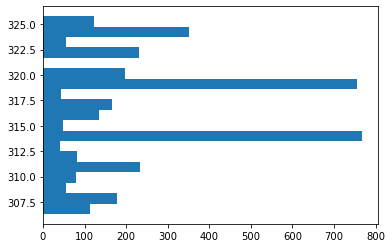

In [194]:
# visualise
new_a = plt.hist(np_str_dist[:, 2], int(max(np_str_dist[:, 2]) - min(np_str_dist[:, 2])), orientation='horizontal')

In [195]:
z_list = sorted(list(set(np_str_dist[:,2])))
for i in range(len(z_list)-1):
    if (z_list[i+1] - z_list[i]) > 0.5:
        gap_start = z_list[i+1]
        break
gap_start   # это будет линия отреза ног, все что выше - траверсы

316.14

In [196]:
# cut again
np_str_dist = np.delete(np_str_dist, np_str_dist[:,2] < gap_start, 0)
print(len(np_str_dist))

2060


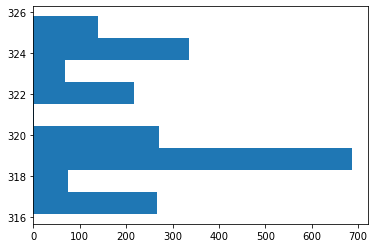

In [197]:
# visualise
new_b = plt.hist(np_str_dist[:,2], int((max(np_str_dist[:,2]) - min(np_str_dist[:,2]))*1), orientation='horizontal')

In [165]:
def xarms_levels(array, segment_size):
    segmented = []
    start = min(array)
    end = start + segment_size
    while end < max(array):
        segmented.append(sum(end > i > start for i in array))
        start += segment_size
        end += segment_size

        
    # then choose only bigger than mean
    ma = []
    biggest = 0
    biggest_nu = 0
    for nu, i in enumerate(segmented):
        if i > (np.mean(segmented)):
            ma.append(round((min(array) + segment_size*nu), 1))
        if i > biggest:
            biggest = i
            biggest_nu = nu
    
    big_one = round((min(array) + segment_size*biggest_nu), 1)
    
    return ma, big_one

In [166]:
# try to split xarms
first_run = xarms_levels(np_str_dist[:,2], 1)[0]   # take 1m step
first_run = sorted(first_run)   # h of xarms after first run

In [167]:
spam = []
for i in range(len(first_run)-1):
    spam.append(first_run[i+1]-first_run[i])
hdist = np.mean(spam)

In [168]:
first_run, spam, hdist

([95.0, 98.0, 101.0], [3.0, 3.0], 3.0)

In [169]:
# then split by arms
arms = []
for i in range(len(first_run)):
    spam = np.delete(np_str_dist, np_str_dist[:,2] < first_run[i], 0)
    if i < len(first_run)-1:
        spam = np.delete(spam, spam[:,2] > first_run[i+1], 0)
    arms.append(spam)


In [170]:
len(arms)

3

In [171]:
# then cut max density on 0.1m
print(len(arms[0]))
level = xarms_levels(arms[0][:,2], 0.1)[1]   # max density
arms[0] = np.delete(arms[0], arms[0][:,2] < level-0.1, 0)
arms[0] = np.delete(arms[0], arms[0][:,2] > level+0.1, 0)
print(len(arms[0]))

89
47


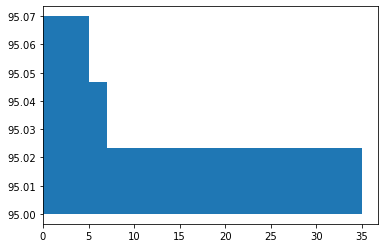

In [172]:
# visualise
new_b = plt.hist(arms[0][:,2], int((max(arms[0][:,2]) - min(arms[0][:,2]))*50), orientation='horizontal')

(1512933.5950000002, 1512939.4249999998, 5365804.4595, 5365811.9505)

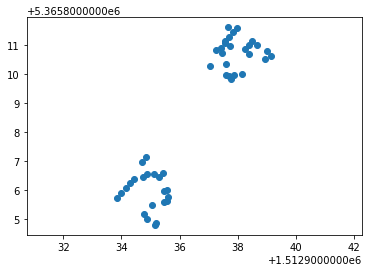

In [173]:
plt.scatter(arms[0][:,0], arms[0][:,1])
plt.axis('equal')

In [174]:
# then select by angle 
# devide to 2 part by angle
# find angle and max len for each part

first_part = []
second_part = []

for i in range(len(arms[0])):
    if i != 0:
        if abs(arms[0][:,3][i]-spam) > 40:
            second_part.append(list(arms[0][i]))
        else:
            first_part.append(list(arms[0][i]))
    else:
        spam = arms[0][:,3][i]
        first_part.append(list(arms[0][i]))

print(len(first_part), len(second_part))


25 22


In [175]:
# cut by length
first_part = np.array(first_part)
first_part = np.delete(first_part, first_part[:,4] < max(first_part[:,4])-0.2, 0)   # cut -0.2 from end

In [176]:
print(np.mean(first_part[:,3]), max(first_part[:,4]))

32.714285714285715 3.62


In [177]:
np.mean(sorted(first_part[:,2])[:5])   # средняя и нижних 5 точек - нижний край траверсы

95.00399999999999

In [178]:
# как финал надо найти ось каждой траверсы (длину, азимут, координаты начала и конца)


In [179]:
second_part = np.array(second_part)
second_part = np.delete(second_part, second_part[:,4] < max(second_part[:,4])-0.2, 0)   # cut -0.2 from end

In [180]:
(np.mean(second_part[:,3]), max(second_part[:,4]))

(209.32000000000002, 3.72)

In [181]:
np.mean(sorted(second_part[:,2]))   # средняя и нижних 5 точек - нижний край траверсы

95.02799999999999

In [182]:
max(second_part[:,4]), max(first_part[:,4])

(3.72, 3.62)

In [183]:
from math import cos, sin, radians

def aztocoords(az, length):
    dx = round(sin(radians(az))*length, 2)
    dy = round(cos(radians(az))*length, 2)
    
    return dx, dy

In [184]:
aztocoords(np.mean(second_part[:,3]), max(second_part[:,4]))   # sec

(-1.82, -3.24)

In [185]:
aztocoords(np.mean(first_part[:,3]), max(first_part[:,4]))  # firts

(1.96, 3.05)

In [186]:
st_p = (cpoint.x + 1.96, cpoint.y + 3.05)

In [187]:
end_p = (cpoint.x -1.82, cpoint.y - 3.24)

(1512933.5950000002, 1512939.4249999998, 5365804.4595, 5365811.9505)

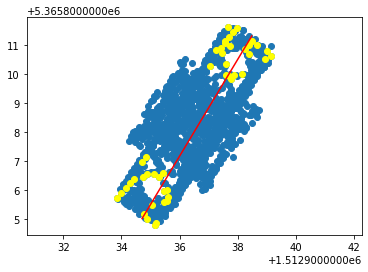

In [188]:
plt.scatter(np_str_cut[:,0], np_str_cut[:,1])
plt.scatter(arms[0][:,0], arms[0][:,1], color='yellow')
plt.plot([(cpoint.x + 1.96), (cpoint.x -1.82)], [cpoint.y + 3.05, cpoint.y - 3.24], color='red')
plt.axis('equal')

In [1]:
a = b = None

In [2]:
for i in range(2):
    if a:
        b = 2
    else:
        a = 3

In [3]:
a, b

(3, 2)

In [6]:
aa = (1, 2, 3)

In [7]:
aa[:2]

(1, 2)